In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Load the .npz file
with np.load("./drive/MyDrive/training_set.npz") as data:
    # Access the arrays by their names
    images = data["images"]  # Assuming 'images' is the key for image data
    labels = data["labels"]  # Assuming 'labels' is the key for label data

# Check the shape of the loaded data
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)



Shape of images: (13759, 96, 96, 3)
Shape of labels: (13759, 1)


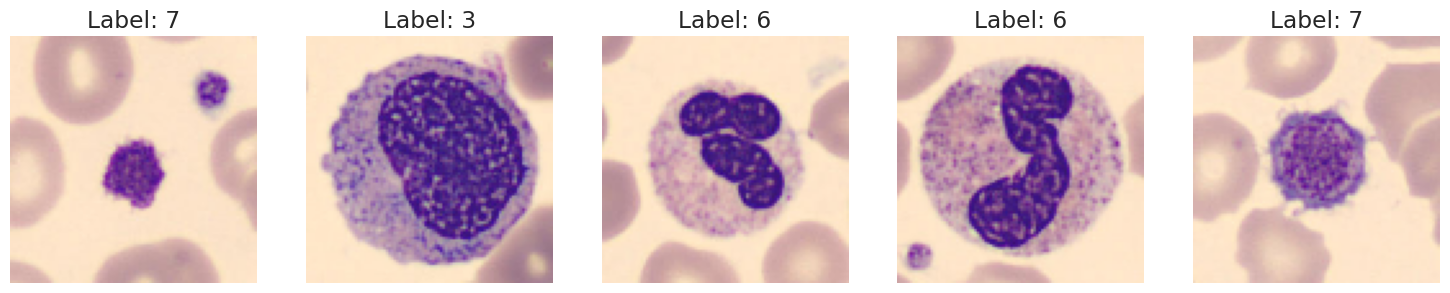

In [ ]:

# Number of images to display
num_images_to_display = 5

# Create a figure and axes for the images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

# Iterate and display images
for i in range(num_images_to_display):
    # Display the image
    axes[i].imshow(images[i])
    axes[i].axis('off')  # Turn off axis labels and ticks
    axes[i].set_title(f"Label: {labels[i][0]}")  # Set title with label

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

In [ ]:
uniqueLabel = np.unique(labels)
unique, count = np.unique(labels, return_counts=True)


In [ ]:
# DO NOT RUN THIS IF YOU WANT TO BUILD MODEL
# Flatten the images into a 2D array (num_images, num_pixels)
num_images = images.shape[0]
num_pixels = images.shape[1] * images.shape[2] * images.shape[3]
flattened_images = images.reshape(num_images, num_pixels)

# Create a DataFrame with pixel values as columns and labels as a separate column
images_df = pd.DataFrame(flattened_images)
images_df['label'] = labels  # Add the labels as a column

In [ ]:
# Batch size: number of samples processed in each training iteration
batch_size = 16

# Number of epochs: times the entire dataset is passed through the network during training
epochs = 100

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=seed,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.1,
    stratify=y_train_val
)


X_train = X_train / 255.0  # Assuming pixel values are in the range 0-255
X_val = X_val / 255.0
X_test = X_test / 255.0



from sklearn.preprocessing import StandardScaler

# Reshape data for StandardScaler
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Apply standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original shape
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)
X_test = X_test_scaled.reshape(X_test.shape)

# Apply one-hot encoding to training labels
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique))

# Apply one-hot encoding to validation labels
y_val = tfk.utils.to_categorical(y_val, num_classes=len(unique))

# Apply one-hot encoding to test labels
y_test = tfk.utils.to_categorical(y_test, num_classes=len(unique))


In [ ]:
# Input shape for the model (get it from X_train)
input_shape = X_train.shape[1:]

# Output shape - needs to be the number of classes
# Assuming labels are integers representing classes, find the number of unique classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Output Shape:", num_classes)  # Print number of classes


# Output shape for the model
output_shape = y_train.shape[1]

Input Shape: (96, 96, 3)
Output Shape: 2


In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(inputs)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)


    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    x = tfkl.Flatten(name='flatten1')(x)

    x = tfkl.Dense(units=output_shape, name='dense')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

# Build the model with specified input and output shapes
model = build_model()


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 24, 24, 64)           │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act3 (Activation)                   │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp3 (MaxPooling2D)                  │ (None, 12, 12, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten1 (Flatten)                  │ (None, 9216)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 8)                    │        73,736 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 8)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 130,056 (508.03 KB)

 Trainable params: 130,056 (508.03 KB)

 Non-trainable params: 0 (0.00 B)

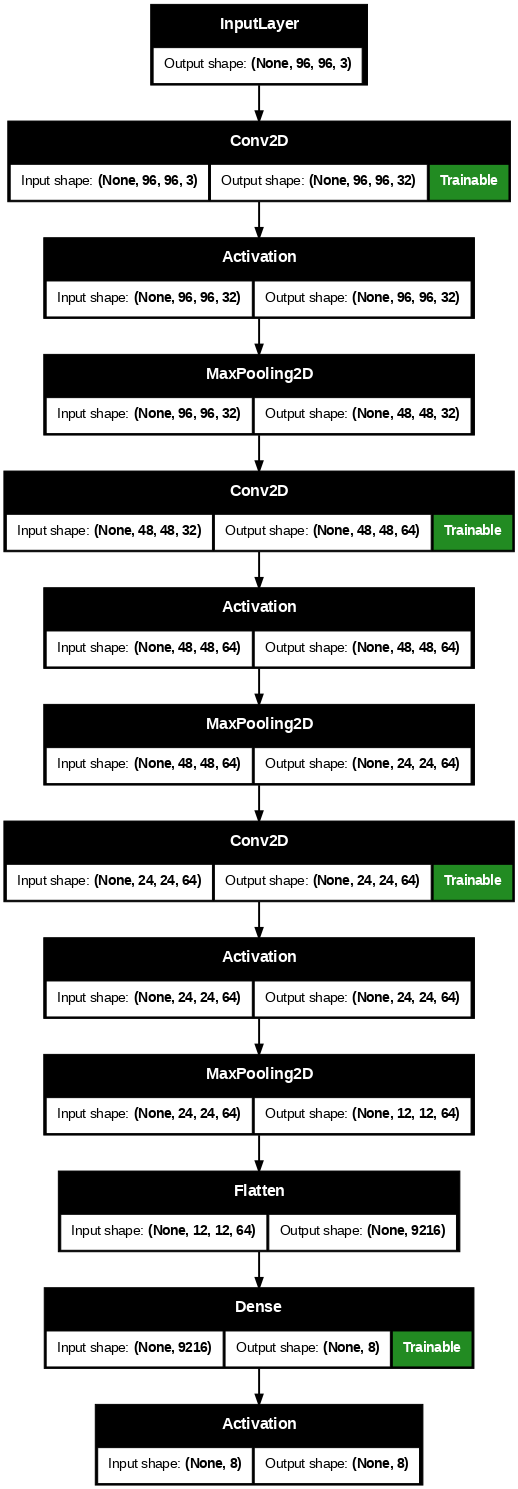

In [ ]:
# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Train the model and store the training history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, y_val)
).history

# Calculate the final validation accuracy
final_val_accuracy = round(history['val_accuracy'][-1] * 100, 2)

# Save the trained model to a file with the accuracy included in the filename
model_filename = f'{final_val_accuracy}.keras'
model.save(model_filename)

# Delete the model to free up memory resources
del model

Epoch 1/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6436 - loss: 0.9451 - val_accuracy: 0.8156 - val_loss: 0.4788
Epoch 2/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8281 - loss: 0.4596 - val_accuracy: 0.8265 - val_loss: 0.4452
Epoch 3/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8527 - loss: 0.3724 - val_accuracy: 0.8474 - val_loss: 0.4039
Epoch 4/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8654 - loss: 0.3319 - val_accuracy: 0.8429 - val_loss: 0.4140
Epoch 5/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8772 - loss: 0.3086 - val_accuracy: 0.8565 - val_loss: 0.4051
Epoch 6/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8868 - loss: 0.2840 - val_accuracy: 0.8392 - val_loss: 0.4524
Epoch 7/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8841 - loss: 0.2797 - val_accuracy: 0.8438 - val_loss: 0.4367
Epoch 8/100
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8908 - loss: 0.2692 - val_acc

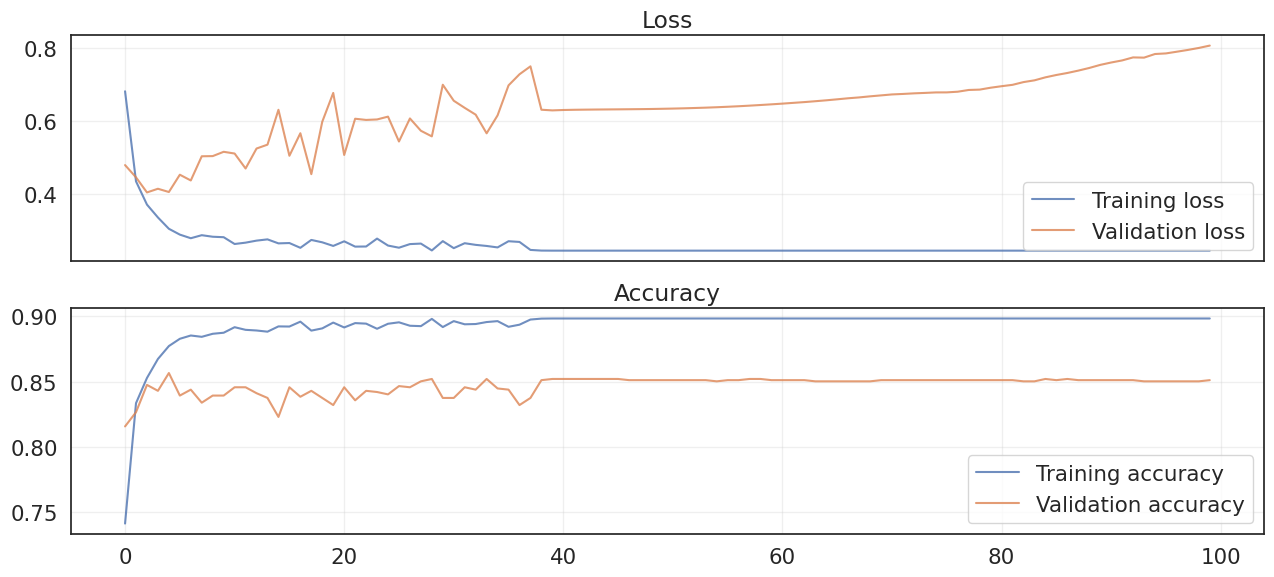

In [ ]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(history['loss'], label='Training loss', alpha=.8)
ax1.plot(history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()